In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation
import nltk
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

from lda import LDA as custom_lda
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer

import time

In [2]:

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load data
data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes')).data
stop_words = set(stopwords.words('english'))

# Preprocessing
def preprocess(doc):
    tokens = nltk.word_tokenize(doc.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]

processed_docs = [preprocess(doc) for doc in data[:2000]]  # sample for speed

# Gensim dictionary and corpus
id2word = corpora.Dictionary(processed_docs)
corpus = [id2word.doc2bow(text) for text in processed_docs]

# Convert to document strings for sklearn vectorizer
docs_joined = [" ".join(doc) for doc in processed_docs]

# Vectorize
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(docs_joined)

start = time.time()
# Train LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

end = time.time()
sklearn_time = end - start
print(f"Time taken: {sklearn_time} seconds")

# Extract topics (words per topic) for coherence model
terms = vectorizer.get_feature_names_out()
topics = []
for topic in lda.components_:
    top_words = [terms[i] for i in topic.argsort()[:-11:-1]]
    topics.append(top_words)

# Compute Coherence Score using Gensim
coherence_model = CoherenceModel(
    topics=topics,
    texts=processed_docs,
    dictionary=id2word,
    coherence='c_v'
)
ref_coherence_score = coherence_model.get_coherence()
print(f"\nCoherence Score: {ref_coherence_score:.4f}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mewie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mewie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Time taken: 4.7639758586883545 seconds

Coherence Score: 0.5273


In [3]:
start = time.time()
custom = custom_lda(n_topics=10, alpha=0.1, beta=0.01, max_iter=50)
custom.fit(X,vectorizer.get_feature_names_out())
end = time.time()
custom_time = end - start
print(f"Time taken: {custom_time} seconds")










Time taken: 289.30209136009216 seconds


In [4]:
# Extract topics (words per topic) for coherence model
topics = []
feature_names = vectorizer.get_feature_names_out()

# Use our own implementation to get top words per topic
for topic_idx in range(custom.n_topics):
    # Calculate word probabilities for this topic with smoothing
    word_probs = (custom.word_topic_counts[:, topic_idx] + custom.beta) / (custom.topic_counts[topic_idx] + custom.beta * len(custom.vocab))
    
    # Get indices of top words
    top_indices = np.argsort(word_probs)[-10:][::-1]
    
    # Get top words
    top_words = [feature_names[idx] for idx in top_indices]
    topics.append(top_words)

# Compute Coherence Score using Gensim
coherence_model = CoherenceModel(
    topics=topics,
    texts=processed_docs,
    dictionary=id2word,
    coherence='c_v'
)
custom_coherence_score = coherence_model.get_coherence()
print(f"\nCoherence Score: {custom_coherence_score:.4f}")


Coherence Score: 0.6139


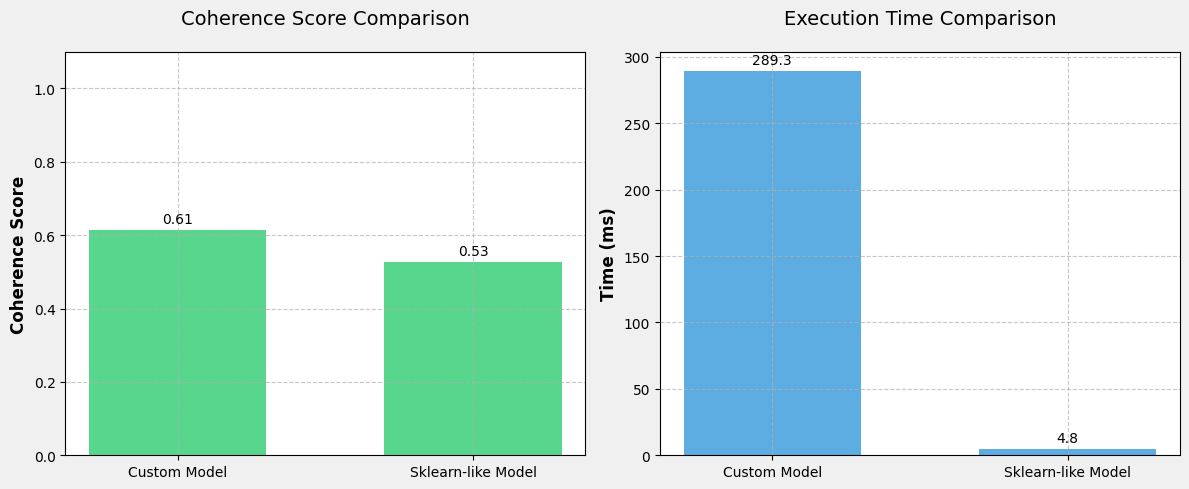

In [6]:
# Setup for plotting with modern style
plt.style.use('default')

# Data preparation
model_names = ['Custom Model', 'Sklearn-like Model']
r2_scores_plot = [custom_coherence_score, ref_coherence_score]
time_taken_plot = [custom_time, sklearn_time]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.patch.set_facecolor('#f0f0f0')

# Set positions for bars
x = np.arange(len(model_names))
width = 0.6

# Create R2 Score bars with modern styling
bars1 = ax1.bar(x, r2_scores_plot, width, color='#2ecc71', alpha=0.8)
ax1.set_ylabel('Coherence Score', fontsize=12, fontweight='bold')
ax1.set_title('Coherence Score Comparison', fontsize=14, pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, fontsize=10)
ax1.set_ylim(0, 1.1)
ax1.grid(True, linestyle='--', alpha=0.7)

# Create Time bars with modern styling
bars2 = ax2.bar(x, time_taken_plot, width, color='#3498db', alpha=0.8)
ax2.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
ax2.set_title('Execution Time Comparison', fontsize=14, pad=20)
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)

# Add value labels with modern styling
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()